# Capstone Project - Moving to Madrid or to Barcelona?
### A data-driven approach

## Table of contents
* Introduction: Business Problem
* Data
* Methodology
* Analysis
* Results and Discussion
* Conclusion

## Introduction: Business Problem

Madrid and Barcelona are the main destination cities for both national people willing to progress and foreigners moving to Spain. This is mainly based on their huge facilities portfolio, their overall business structure and a rich high-quality jobs offer.

But, where to move? There are countless online and offline resources from which you can pull information about where your dreamed job may be. But little to no remote options are available to check objective information about what you can do in your personal life, when the working time is over, and how to compare those two cities in regards to such aspect of your life.

Everybody has their own needs, so we will focus on a given ‘persona’ profile very likely to be a national and/or international migrant. This ‘persona’ profile consists of:
* young people without children,
* likely with pets,
* and lovers of the natural life.

These people usually have a higher than average level of spending, which is a driver for local entities to attract such kind of talent too.

We will use data science to chose which of the two cities is the most appropriate one for such 'persona' profile looking for a downtown 'natural way of life', and later to provide options on the most promising neighborhoods based on this criteria and the economic capabilities of the possible diverse migrants.

## Data

Based on the definition of our problem, the main factors to decide which of the two cities is the most appropriated destination for a migrant looking for a natural and high standard way of life will be:
* which one has the biggest amount of venues linked to natural way of life (healthy restaurants and shops, sport areas, natural walkways, etc.)
* which one has those natural venues more equally distributed across neighborhoods, so that once chosen a destination city there might be more options to find the right neighborhood amongst a wider offer. 

Once the final destination city is chosen, neighborhoods of similar characteristics will be clustered. Once the most 'natural' candidate cluster is chosen, there will be a cross-reference between possible migrant salary and the affordable renting options amongst neighborhoods in such cluster. 

Following data sources will be needed to extract/generate the required information:
* Wikipedia sites will be parsed with `BeautifulSoup` library for districts and neighborhoods structure
* obtain coordiantes data from a mix of Wikipedia and `Geohack` sites
* use the `Foursquare API` to extract the most relevant venues per neighborhood
* summarize information per city based on a selection of venues
* incorporate datsets of information around: average building measures by neighborhoods, average renting price by neighborhood and average salaries for a set of alternative jobs for the migrant.

### Madrid and Barcelona districts and neighborhoods structure and coordinates

The process to extract the diverse districts and neighborhoods as well as their respective coordinates for both Madrid and Barcelona was:

- extract districts and neighborhoods structure from Wikipedia sites for Madrid $^{ (1)}$ and Barcelona $^{ (2)}$
- since in Spain there is a complete lack of alignment between postal codes and neighborhoods it was impossible to use geolocation libraries like `geopy` or `pgeocode` to extract dynamically the coordinates from those; thus, some manual work was required to pool data from Wikipedia + Geohack $^{ (3)}$ site to get coordinates information
- the coordinates information was included as dictionaries and converted into dataframes for later processing.

In [1]:
#import required libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup

# set the options of the dataframe display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Madrid districts and neighborhoods extraction

As a first step, we need to extract the information from Wikipedia Madrid districts and neighborhoods site by parsing the table including such content:

In [2]:
# define seed url
url_mad = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_of_Madrid'

# identify table class
table_class = "wikitable sortable jquery-tablesorter"

# define headers to avoid banning
headers = {
    "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/71.0.3578.80 Chrome/71.0.3578.80 Safari/537.36"
}

# make a request
response_mad = requests.get(url_mad, headers = headers)

# parse data from the html into a beautifulsoup object
soup_mad = BeautifulSoup(response_mad.text, 'html.parser')
mad_table = soup_mad.find('table', {'class':"wikitable"})

# read html and covert into a dataframe
df_mad = pd.read_html(str(mad_table))
df_mad = pd.DataFrame(df_mad[0])

# repurpose dataframe to include only some columns
df_mad = df_mad.drop(['District location', 'Number', 'Image'], axis = 1)

# rename columns for easier display
df_mad = df_mad.rename(columns = {"District name (number)": "District", "Name": "Neighborhood"})

Since in the Wikipedia table the diverse districts of Madrid are listed with a number within the same string and also we need to remove the stress signs and the 'ñ' letters to avoid latter issues with mapping in both districts and neighborhoods, we need to do some additional work on the data:

In [3]:
# define old and new values lists for districts
old_district = ['Centro (1)', 'Arganzuela (2)', 'Retiro (3)', 'Salamanca (4)', 'Chamartín (5)', 'Tetuán (6)', 'Chamberí (7)', 'Fuencarral-El Pardo (8)', 'Moncloa-Aravaca (9)', 'Latina (10)', 'Carabanchel (11)', 'Usera (12)', 'Puente de Vallecas (13)', 'Moratalaz (14)', 'Ciudad Lineal (15)', 'Hortaleza (16)', 'Villaverde (17)', 'Villa de Vallecas (18)', 'Vicálvaro (19)', 'San Blas-Canillejas (20)', 'Barajas (21)']
new_district = ['Centro', 'Arganzuela', 'Retiro', 'Salamanca', 'Chamartin', 'Tetuan', 'Chamberi', 'Fuencarral-El Pardo', 'Moncloa-Aravaca', 'Latina', 'Carabanchel', 'Usera', 'Puente de Vallecas', 'Moratalaz', 'Ciudad Lineal', 'Hortaleza', 'Villaverde', 'Villa de Vallecas', 'Vicalvaro', 'San Blas-Canillejas', 'Barajas']

# generate a loop to replace all elements in the districts list
for i in range(len(old_district)):
    df_mad['District'] = df_mad['District'].astype(str).replace(old_district[i], new_district[i])

# define old and new values lists for neighborhoods
old_neigh = ['Pacífico', 'Los Jerónimos', 'Niño Jesús', 'Ciudad Jardín', 'Hispanoamérica', 'Nueva España', 'Ríos Rosas', 'Peñagrande', 'Argüelles', 'Valdemarín', 'El Plantío', 'Los Cármenes', 'Puerta del Ángel', 'Las Águilas', 'Opañel', 'San Fermín', 'Moscardó', 'Entrevías', 'Fontarrón', 'Concepción', 'Apóstol Santiago', 'San Cristóbal', 'Los Ángeles', 'Casco Histórico de Vallecas', 'El Cañaveral', 'Hellín', 'Casco Histórico de Barajas', 'Timón']
new_neigh = ['Pacifico', 'Los Jeronimos', 'Nino Jesus', 'Ciudad Jardin', 'Hispanoamerica', 'Nueva Espana', 'Rios Rosas', 'Penagrande', 'Arguelles', 'Valdemarin', 'El Plantio', 'Los Carmenes', 'Puerta del Angel', 'Las Aguilas', 'Opanel', 'San Fermin', 'Moscardo', 'Entrevias', 'Fontarron', 'Concepcion', 'Apostol Santiago', 'San Cristobal', 'Los Angeles', 'Casco Historico de Vallecas', 'El Canaveral', 'Hellin', 'Casco Historico de Barajas', 'Timon']

# generate a loop to replace all elements in the districts list
for i in range(len(old_neigh)):
    df_mad['Neighborhood'] = df_mad['Neighborhood'].astype(str).replace(old_neigh[i], new_neigh[i])

#### Madrid neighborhood coordinates

We will incorporate the coordinates information for the Madrid neighborhoods into a dictionary which will be immediately converted into a dataframe:

In [4]:
# dictionary extracted from Geohack with Madrid neighborhoods coordinates
mad_coord = {'Palacio': [40.415, -3.713333], 'Embajadores': [40.408889, -3.699722], 'Cortes': [40.414167, -3.698056], 'Justicia': [40.423889, -3.696389], 'Universidad': [40.425278, -3.708333], 'Sol': [40.416667, -3.703889], 'Imperial': [40.406667, -3.716944], 'Acacias': [40.401422, -3.704936], 'Chopera': [40.395, -3.699444], 'Legazpi': [40.388611, -3.695178], 'Delicias': [40.395833, -3.689444], 'Palos de Moguer': [40.403889, -3.693889], 'Atocha': [40.400819, -3.683681], 'Pacifico': [40.404722, -3.675833], 'Adelfas': [40.400278, -3.670833], 'Estrella': [40.413611, -3.664167], 'Ibiza': [40.418889, -3.674167], 'Los Jeronimos': [40.413889, -3.690833], 'Nino Jesus': [40.411667, -3.673889], 'Recoletos': [40.424167, -3.686389], 'Goya': [40.425278, -3.674722], 'Fuente del Berro': [40.424722, -3.663889], 'Guindalera': [40.435833, -3.668333], 'Lista': [40.432778, -3.674444], 'Castellana': [40.433333, -3.684722], 'El Viso': [40.4444, -3.6888], 'Prosperidad': [40.445, -3.67], 'Ciudad Jardin': [40.446944, -3.671667], 'Hispanoamerica': [40.455556, -3.676667], 'Nueva Espana': [40.463056, -3.6775], 'Castilla': [40.475, -3.678889], 'Bellas Vistas': [40.452458, -3.70719], 'Cuatro Caminos': [40.450278, -3.695833], 'Castillejos': [40.461389, -3.6925], 'Almenara': [40.4713, -3.6955], 'Valdeacederas': [40.468611, -3.705556], 'Berruguete': [40.4575, -3.705556], 'Gaztambide': [40.434722, -3.714722], 'Arapiles': [40.434167, -3.707778], 'Trafalgar': [40.433056, -3.700556], 'Almagro': [40.431667, -3.694167], 'Rios Rosas': [40.442222, -3.697222], 'Vallehermoso': [40.442778, -3.711667], 'El Pardo': [40.516667, -3.766667], 'Fuentelarreina': [40.481944, -3.7425], 'Penagrande': [40.478056, -3.725556], 'Pilar': [40.476944, -3.7125], 'La Paz': [40.481389, -3.696944], 'Valverde': [40.505833, -3.685833], 'Mirasierra': [40.491667, -3.708056], 'El Goloso': [40.556111, -3.703333], 'Casa de Campo': [40.481944, -3.7425], 'Arguelles': [40.427778, -3.717778], 'Ciudad Universitaria': [40.443772, -3.726136], 'Valdezarza': [40.465, -3.718333], 'Valdemarin': [40.472561, -3.780239], 'El Plantio': [40.4708, -3.825561], 'Aravaca': [40.45, -3.783333], 'Los Carmenes': [40.406944, -3.726389], 'Puerta del Angel': [40.411944, -3.729722], 'Lucero': [40.410556, -3.735833], 'Aluche': [40.3875, -3.754167], 'Campamento': [40.3875, -3.781944], 'Cuatro Vientos': [40.3775, -3.791111], 'Las Aguilas': [40.3775, -3.764167], 'Comillas': [40.392778, -3.713889], 'Opanel': [40.388889, -3.728056], 'San Isidro': [40.398889, -3.726389], 'Vista Alegre': [40.386111, -3.738889], 'Puerta Bonita': [40.381944, -3.736389], 'Buenavista': [40.366667, -3.755], 'Abrantes': [40.380556, -3.723889], 'Orcasitas': [40.368611, -3.711944], 'Orcasur': [40.367222, -3.699167], 'San Fermin': [40.371667, -3.688333], 'Almendrales': [40.383611, -3.698889], 'Moscardo': [40.39, -3.707778], 'Zofío': [40.379167, -3.715278], 'Pradolongo': [40.378333, -3.706111], 'Entrevias': [40.4, -3.683333], 'San Diego': [40.396389, -3.667222], 'Palomeras Bajas': [40.387222, -3.657222], 'Palomeras Sureste': [40.387778, -3.639444], 'Portazgo': [40.3925, -3.649722], 'Numancia': [40.400833, -3.663056], 'Pavones': [40.394722, -3.633056], 'Horcajo': [40.411389, -3.626944], 'Marroquina': [40.411111, -3.641111], 'Media Legua': [40.414167, -3.654722], 'Fontarron': [40.40139, -3.64528], 'Vinateros': [40.403056, -3.640278], 'Ventas': [40.428333, -3.6575], 'Pueblo Nuevo': [40.425278, -3.635278], 'Quintana': [40.4375, -3.642222], 'Concepcion': [40.440278, -3.648056], 'San Pascual': [40.4425, -3.6525], 'San Juan Bautista': [40.45, -3.656667], 'Colina': [40.456667, -3.661944], 'Atalaya': [40.466111, -3.666944], 'Costillares': [40.4744, -3.6697], 'Palomas': [40.453611, -3.618056], 'Piovera': [40.453611, -3.640278], 'Canillas': [40.459722, -3.645556], 'Pinar del Rey': [40.464722, -3.655556], 'Apostol Santiago': [40.476389, -3.658056], 'Valdefuentes': [40.490556, -3.623889], 'Villaverde Alto': [40.347778, -3.711667], 'San Cristobal': [40.343333, -3.688611], 'Butarque': [40.343611, -3.679722], 'Los Rosales': [40.360278, -3.685556], 'Los Angeles': [40.356667, -3.699167], 'Casco Historico de Vallecas': [40.359444, -3.636389], 'Santa Eugenia': [40.383333, -3.611389], 'Ensanche de Vallecas': [40.365528, -3.603264], 'Casco Histórico de Vicálvaro': [40.396944, -3.615], 'Valdebernardo': [40.400046, -3.621561], 'Valderrivas': [40.401583, -3.599094], 'El Canaveral': [40.401433, -3.552617], 'Simancas': [40.428056, -3.625278], 'Hellin': [40.430278, -3.618889], 'Amposta': [40.430278, -3.619444], 'Arcos': [40.423889, -3.613056], 'Rosas': [40.436111, -3.599444], 'Rejas': [40.443611, -3.595], 'Canillejas': [40.45, -3.616667], 'El Salvador': [40.444444, -3.633056], 'Alameda de Osuna': [40.428056, -3.625278], 'Aeropuerto': [40.494167, -3.566944], 'Casco Historico de Barajas': [40.473611, -3.577222], 'Timon': [40.476667, -3.614167], 'Corralejos': [40.464444, -3.59]}

# generate a dataframe from dictionary
df_mad_coord = pd.DataFrame.from_dict(mad_coord, orient = 'index')
df_mad_coord.reset_index(level = 0, inplace = True)
df_mad_coord.columns = ['Neighborhood', 'Latitude', 'Longitude']

Once information on the Madrid neighborhoods coordinates captured into a dataframe, we will merge it with the parsed info from Wikipedia into a single dataframe for Madrid:

In [5]:
mad_neigh_coord = pd.merge(df_mad, df_mad_coord, on='Neighborhood')

# display shape and dataframe head
print(mad_neigh_coord.shape)
mad_neigh_coord.head()

(131, 4)


,District,Neighborhood,Latitude,Longitude
0,Centro,Palacio,40.415000,-3.713333
1,Centro,Embajadores,40.408889,-3.699722
2,Centro,Cortes,40.414167,-3.698056
3,Centro,Justicia,40.423889,-3.696389
4,Centro,Universidad,40.425278,-3.708333


#### Barcelona districts and neighborhoods extraction

As a first step, we need to extract the information from Wikipedia Barcelona districts and neighborhoods site by parsing the table including such content:

In [6]:
# define seed url
url_bcn = 'https://en.wikipedia.org/wiki/Districts_of_Barcelona'

# identify table class
table_class = "wikitable"

# define headers to avoid banning
headers = {
    "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/71.0.3578.80 Chrome/71.0.3578.80 Safari/537.36"
}

# make a request
response_bcn = requests.get(url_bcn, headers = headers)

# parse data from the html into a beautifulsoup object
soup_bcn = BeautifulSoup(response_bcn.text, 'html.parser')
bcn_table = soup_bcn.find('table', {'class':"wikitable"})

# read html and covert into a dataframe
df_bcn = pd.read_html(str(bcn_table))
df_bcn = pd.DataFrame(df_bcn[0])

# repurpose dataframe to include only some columns
df_bcn = df_bcn.drop(['Number', 'Size km2', 'Population', 'Density inhabitants/km2', 'Councilman[2]', 'Party'], axis = 1)

# rename columns for easier display
df_bcn = df_bcn.rename(columns = {"Neighbourhoods": "Neighborhood"})

Since in the Wikipedia table the diverse neighborhoods of Barcelona are listed by district row as a comma-separated list, and there are some typos and mismatching which may influence later when trying to merge info from another sources into a single dataframe, we need to do some additional work on the data, including separating elements within row and to explode each of those elements into a different row: 

In [7]:
# generate lists of elements to replace and those replacing the former 
old = []
for i in range(df_bcn.shape[0]):
    old.append(df_bcn['Neighborhood'][i])

new = ["La Barceloneta,El Gotic,El Raval,Sant Pere Santa Caterina i la Ribera","LAntiga Esquerra de lEixample,La Nova Esquerra de lEixample,Dreta de lEixample,Fort Pienc,Sagrada Familia,Sant Antoni","La Bordeta,La Font de la Guatlla,Hostafrancs,La Marina de Port,La Marina del Prat Vermell,El Poblesec,Sants,Sants Badal,Montjuic,Zona Franca Port","Les Corts,La Maternitat i Sant Ramon,Pedralbes","Vallvidrera el Tibidabo i les Planes,Sarria,El Puget i Farro,Les Tres Torres,Sant Gervasi la Bonanova,Sant Gervasi Galvany","Vila de Gracia,El Camp den Grassot i Gracia Nova,La Salut,El Coll,Vallcarca i els Penitents","El Baix Guinardo,El Guinardo,Can Baro,El Carmel,La Font den Fargues,Horta,La Clota,Montbau,Sant Genis dels Agudells,La Teixonera,La Vall dHebron","Can Peguera,Canyelles,Ciutat Meridiana,La Guineueta,Porta,La Prosperitat,Les Roquetes,Torre Baro,La Trinitat Nova,El Turo de la Peira,Vallbona,Verdum,Vilapicina i la Torre Llobeta","Baro de Viver,Bon Pastor,El Congres i els Indians,Navas,Sant Andreu de Palomar,La Sagrera,La Trinitat Vella","El Besos i el Maresme,El Clot,El Camp de lArpa del Clot,Diagonal Mar i el Front Maritim del Poblenou,El Parc i la Llacuna del Poblenou,Poblenou,Provencals del Poblenou,Sant Marti de Provencals,La Verneda i la Pau,La Vila Olimpica del Poblenou"]

# generate a loop to replace all elements in the list
for i in range(df_bcn.shape[0]):
    df_bcn['Neighborhood'] = df_bcn['Neighborhood'].astype(str).replace(old[i], new[i])

# explode list of elements into different rows
df_bcn = df_bcn.assign(Neighborhood = df_bcn.Neighborhood.str.split(",")).explode('Neighborhood').reset_index().drop('index', axis = 1)

#### Barcelona neighborhood coordinates

We will incorporate the coordinates information for the Barcelona neighborhoods into a dictionary which will be immediately converted into a dataframe:

In [8]:
# dictionary extracted from Geohack with Barcelona neighborhoods coordinates
bcn_coord = {'El Raval': [41.380000, 2.168610], 'El Gotic': [41.382778, 2.176944], 'La Barceloneta': [41.379440, 2.189170], 'Sant Pere Santa Caterina i la Ribera': [41.384700, 2.182600], 'Fort Pienc': [41.395675, 2.183703], 'Sagrada Familia': [41.403561, 2.174347], "Dreta de lEixample": [41.395278, 2.166667], "LAntiga Esquerra de lEixample": [41.390061, 2.155061], "La Nova Esquerra de lEixample": [41.383389, 2.149000], 'Sant Antoni': [41.378010, 2.159490], 'El Poblesec': [41.372780, 2.162500], 'La Marina del Prat Vermell': [41.352103, 2.139436], 'La Marina de Port': [41.359583, 2.140972], 'La Font de la Guatlla': [41.369681, 2.144811], 'Hostafrancs': [41.375556, 2.143056], 'La Bordeta': [41.370494, 2.137097], 'Sants Badal': [41.375278, 2.126667], 'Sants': [41.383333, 2.150000], 'Zona Franca Port': [41.333333, 2.138611], 'Montjuic': [41.364167, 2.158056], 'Les Corts': [41.384167, 2.132778], 'La Maternitat i Sant Ramon': [41.384342, 2.122206], 'Pedralbes': [41.394722, 2.113056], 'Vallvidrera el Tibidabo i les Planes': [41.416667, 2.100000], 'Sarria': [41.399431, 2.121867], 'Les Tres Torres': [41.398611, 2.131111], 'Sant Gervasi la Bonanova': [41.406389, 2.133611], 'Sant Gervasi Galvany': [41.396667, 2.143889], 'El Puget i Farro': [41.405556, 2.145278], 'Vallcarca i els Penitents': [41.412778, 2.143056], 'El Coll': [41.418056, 2.145833], 'La Salut': [41.412478, 2.151431], 'Vila de Gracia': [41.404047, 2.155894], "El Camp den Grassot i Gracia Nova": [41.406110, 2.167220], 'El Baix Guinardo': [41.409228, 2.166922], 'Can Baro': [41.416384, 2.162356], 'El Guinardo': [41.418378, 2.175561], "La Font den Fargues": [41.424917, 2.165528], 'El Carmel': [41.418336, 2.154436], 'La Teixonera': [41.423131, 2.145853], 'Sant Genis dels Agudells': [41.428506, 2.132547], 'Montbau': [41.430925, 2.142967], "La Vall dHebron": [41.431624, 2.148853], 'La Clota': [41.429444, 2.153611], 'Horta': [41.429503, 2.160100], 'Vilapicina i la Torre Llobeta': [41.428761, 2.170872], 'Porta': [41.434650, 2.174947], 'El Turo de la Peira': [41.433008, 2.165808], 'Can Peguera': [41.434900, 2.166188], 'La Guineueta': [41.441342, 2.171986], 'Canyelles': [41.442684, 2.166015], 'Les Roquetes': [41.448644, 2.172031], 'Verdum': [41.443333, 2.175000], 'La Prosperitat': [41.442661, 2.181686], 'La Trinitat Nova': [41.448581, 2.185247], 'Torre Baro': [41.458356, 2.180782], 'Ciutat Meridiana': [41.460914, 2.174433], 'Vallbona': [41.462331, 2.182908], 'La Trinitat Vella': [41.450180, 2.191360], 'Baro de Viver': [41.447906, 2.200742], 'Bon Pastor': [41.436347, 2.201328], 'Sant Andreu de Palomar': [41.436111, 2.191667], 'La Sagrera': [41.422358, 2.186319], 'El Congres i els Indians': [41.425881, 2.180678], 'Navas': [41.415744, 2.186900], "El Camp de lArpa del Clot": [41.411433, 2.182500], 'El Clot': [41.407848, 2.188822], 'El Parc i la Llacuna del Poblenou': [41.399167, 2.190833], 'La Vila Olimpica del Poblenou': [41.389800, 2.196590], 'Poblenou': [41.399167, 2.203889], 'Diagonal Mar i el Front Maritim del Poblenou': [41.409600, 2.216306], 'El Besos i el Maresme': [41.417178, 2.213572], 'Provencals del Poblenou': [41.409400, 2.200560], 'Sant Marti de Provencals': [41.417222, 2.198056], 'La Verneda i la Pau': [41.421950, 2.205311]}

# generate a dataframe from dictionary
df_bcn_coord = pd.DataFrame.from_dict(bcn_coord, orient = 'index')
df_bcn_coord.reset_index(level = 0, inplace = True)
df_bcn_coord.columns = ['Neighborhood', 'Latitude', 'Longitude']

Once information on the Barcelona neighborhoods coordinates captured into a dataframe, we will merge it with the parsed info from Wikipedia into a single dataframe for Barcelona:

In [9]:
bcn_neigh_coord = pd.merge(df_bcn, df_bcn_coord, on='Neighborhood')

# display shape and dataframe head
print(bcn_neigh_coord.shape)
bcn_neigh_coord.head()

(75, 4)


,District,Neighborhood,Latitude,Longitude
0,Ciutat Vella,La Barceloneta,41.379440,2.189170
1,Ciutat Vella,El Gotic,41.382778,2.176944
2,Ciutat Vella,El Raval,41.380000,2.168610
3,Ciutat Vella,Sant Pere Santa Caterina i la Ribera,41.384700,2.182600
4,Eixample,LAntiga Esquerra de lEixample,41.390061,2.155061


### Madrid and Barcelona categorized venues

#### Foursquare API settings

Once we have extracted the neighborhoods´ coordinates for both cities, let's use the Foursquare API to get info on venues by neighborhood.

We're looking for venues in general. We will use 1km of radius around each neighborhood center coordinate and later we will de-dupe possible repeated venues based on areas overlap. This would make venues collection more exhaustive.

Foursquare credentials are defined in hidden cell bellow.

In [10]:
# Foursquare ID
CLIENT_ID = 'CLIENT_ID' 

# Foursquare Secret
CLIENT_SECRET = 'CLIENT_SECRET' 

# FourSquare Access Token
ACCESS_TOKEN = 'ACCESS_TOKEN' 

In [11]:
# Foursquare API version
VERSION = '20180605'

# a default Foursquare API limit value
LIMIT = 100 

# set a big radius value to cover all possible space
RADIUS = 1000

In [12]:
# define a function to extract the venues per neighborhood
def getNearbyVenues(districts, hoods, latitudes, longitudes, radius = RADIUS):

    venues_list = []
    print('Obtaining venues around candidate locations:', end='')
    for district, hood, lat, lng in zip(districts, hoods, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, RADIUS, LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            district,
            hood,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        print(' .', end='')
    print(' done.')

    nearby_venues = pd.DataFrame(
        [item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 'Neighborhood', 'Neighborhood Lat',
                             'Neighborhood Lon', 'Venue', 'Venue Lat', 'Venue Lon', 'Venue Category']

    return(nearby_venues)

#### Foursquare venues collection by neighborhood in Madrid

In [13]:
# neighborhood latitude values
lat = mad_neigh_coord.loc[:, 'Latitude']

# neighborhood longitude values
lng = mad_neigh_coord.loc[:, 'Longitude'] 

In [14]:
# try to load from local file system in case we did this before

loaded = False
try:
    mad_venues = pd.read_csv('csv/mad_venues.csv', index_col = 0)
    print('Madrid venues data loaded.')
    loaded = True
except:
    pass

# if load failed use the Foursquare API to get the data
if not loaded:
    mad_venues = getNearbyVenues(districts = mad_neigh_coord['District'], hoods = mad_neigh_coord['Neighborhood'],
                                 latitudes = mad_neigh_coord['Latitude'], longitudes = mad_neigh_coord['Longitude'])
    
    print('This is the original shape of the dataframe before de-duping venues: ' + str(mad_venues.shape))
    
    # drop duplicated venues due to cross-neighborhood occurrences
    mad_venues = mad_venues.drop_duplicates(subset = ['Venue']).reset_index()
    mad_venues = mad_venues.drop(['index'], axis = 1)
    
    # let's persists this in local file system
    mad_venues.to_csv('csv/mad_venues.csv')

# display dataframe head and additional information
print('There are {} venues in {} unique categories.'.format(mad_venues.shape[0], len(mad_venues['Venue Category'].unique())))
mad_venues.head()

Madrid venues data loaded.
There are 3356 venues in 290 unique categories.


,District,Neighborhood,Neighborhood Lat,Neighborhood Lon,Venue,Venue Lat,Venue Lon,Venue Category
0,Centro,Palacio,40.415,-3.713333,Santa Iglesia Catedral de Santa María la Real ...,40.415767,-3.714516,Church
1,Centro,Palacio,40.415,-3.713333,Taberna Rayuela,40.413179,-3.713496,Tapas Restaurant
2,Centro,Palacio,40.415,-3.713333,Cervecería La Mayor,40.415218,-3.712194,Beer Bar
3,Centro,Palacio,40.415,-3.713333,Zuccaru,40.417179,-3.711674,Ice Cream Shop
4,Centro,Palacio,40.415,-3.713333,Plaza de La Almudena,40.416320,-3.713777,Plaza


#### Foursquare venues collection by neighborhood in Barcelona

In [15]:
# neighborhood latitude values
lat = bcn_neigh_coord.loc[:, 'Latitude']

# neighborhood longitude values
lng = bcn_neigh_coord.loc[:, 'Longitude'] 

In [16]:
# try to load from local file system in case we did this before

loaded = False
try:
    bcn_venues = pd.read_csv('csv/bcn_venues.csv', index_col = 0)
    print('Barcelona venues data loaded.')
    loaded = True
except:
    pass

# if load failed use the Foursquare API to get the data
if not loaded:
    bcn_venues = getNearbyVenues(districts = bcn_neigh_coord['District'], hoods = bcn_neigh_coord['Neighborhood'],
                                 latitudes = bcn_neigh_coord['Latitude'], longitudes = bcn_neigh_coord['Longitude'])
    
    print('This is the original shape of the dataframe before de-duping venues: ' + str(bcn_venues.shape))
    
    # drop duplicated venues due to cross-neighborhood occurrences
    bcn_venues = bcn_venues.drop_duplicates(subset = ['Venue']).reset_index()
    bcn_venues = bcn_venues.drop(['index'], axis = 1)
    
    # let's persists this in local file system
    bcn_venues.to_csv('csv/bcn_venues.csv')

# display dataframe head and additional information
print('There are {} venues in {} unique categories.'.format(bcn_venues.shape[0], len(bcn_venues['Venue Category'].unique())))
bcn_venues.head()

Barcelona venues data loaded.
There are 2582 venues in 285 unique categories.


,District,Neighborhood,Neighborhood Lat,Neighborhood Lon,Venue,Venue Lat,Venue Lon,Venue Category
0,Ciutat Vella,La Barceloneta,41.37944,2.18917,Baluard Barceloneta,41.380047,2.189250,Bakery
1,Ciutat Vella,La Barceloneta,41.37944,2.18917,La Cova Fumada,41.379254,2.189254,Tapas Restaurant
2,Ciutat Vella,La Barceloneta,41.37944,2.18917,Plaça de la Barceloneta,41.379739,2.188135,Plaza
3,Ciutat Vella,La Barceloneta,41.37944,2.18917,NAP Mar,41.377530,2.190055,Pizza Place
4,Ciutat Vella,La Barceloneta,41.37944,2.18917,acqua&farina,41.381023,2.190152,Pizza Place


### Madrid and Barcelona 'natural' venues extraction

#### Natural venues extraction in Madrid

First, we need to generate a summary dataframe for Madrid city in which we will select a sub-set of venues based on their link with natural life, which will be define based on a subjective criteria: 

In [17]:
# generate a new dataframe based on grouped data by venue category
mad_grouped = mad_venues.groupby('Venue Category').count().reset_index()
mad_grouped = mad_grouped.rename(columns = {"Venue": "Venue Count"})
mad_grouped = mad_grouped[['Venue Category', 'Venue Count']]

# define list of venues linked to natural life
mad_nat_venues = ['Athletics & Sports', 'Basketball Court', 'Beach', 'Bike Shop', 'Comfort Food Restaurant', 'Dog Run', 'Falafel Restaurant', 'Farmers Market', 'Fruit & Vegetable Store', 'Garden', 'Grocery Store', 'Gym', 'Gym / Fitness Center', 'Gym Pool', 'Health Food Store', 'Juice Bar', 'Market', 'Park', 'Pet Café', 'Pet Store', 'Pool', 'Salad Place', 'Soccer Field', 'Sporting Goods Shop', 'Tennis Court', 'Vegetarian / Vegan Restaurant', 'Yoga Studio']

# subset grouped dataframe based on natural life
mad_nat_grouped = mad_grouped.loc[mad_grouped['Venue Category'].isin(mad_nat_venues)].reset_index().drop(['index'], axis = 1)

# create a new category grouping based on items: sports, walkways, healthy shops, healthy restaurants, pet places
mad_nat_grouped['Venue Category'] = mad_nat_grouped['Venue Category'].replace(['Athletics & Sports', 'Basketball Court', 'Bike Shop', 'Gym', 'Gym / Fitness Center', 'Gym Pool', 'Pool', 'Soccer Field', 'Sporting Goods Shop', 'Tennis Court', 'Yoga Studio'], 'sports')
mad_nat_grouped['Venue Category'] = mad_nat_grouped['Venue Category'].replace(['Beach', 'Garden', 'Park'], 'walkways')
mad_nat_grouped['Venue Category'] = mad_nat_grouped['Venue Category'].replace(['Farmers Market', 'Fruit & Vegetable Store', 'Grocery Store', 'Health Food Store', 'Market'], 'healthy shops')
mad_nat_grouped['Venue Category'] = mad_nat_grouped['Venue Category'].replace(['Comfort Food Restaurant', 'Falafel Restaurant', 'Juice Bar', 'Salad Place', 'Vegetarian / Vegan Restaurant'], 'healthy restaurants')
mad_nat_grouped['Venue Category'] = mad_nat_grouped['Venue Category'].replace(['Dog Run', 'Pet Café', 'Pet Store'], 'pet places')

# group data rename column
mad_nat_grouped = mad_nat_grouped.groupby('Venue Category').sum().reset_index()
mad_nat_grouped = mad_nat_grouped.rename(columns = {"Venue Category": "Natural Category"})

# review dataframe
mad_nat_grouped

,Natural Category,Venue Count
0,healthy restaurants,28
1,healthy shops,71
2,pet places,6
3,sports,194
4,walkways,117


Later, we need to generate a detailed dataframe for Madrid city in which we will select venues based on their link with natural life:

In [18]:
# subset complete dataframe based on natural life venues
mad_natural = mad_venues.loc[mad_venues['Venue Category'].isin(mad_nat_venues)].reset_index().drop(['index'], axis = 1)

# create a new category grouping based on items: sports, walkways, healthy shops, healthy restaurants, pet places
mad_natural['Venue Category'] = mad_natural['Venue Category'].replace(['Athletics & Sports', 'Basketball Court', 'Bike Shop', 'Gym', 'Gym / Fitness Center', 'Gym Pool', 'Pool', 'Soccer Field', 'Sporting Goods Shop', 'Tennis Court', 'Yoga Studio'], 'sports')
mad_natural['Venue Category'] = mad_natural['Venue Category'].replace(['Beach', 'Garden', 'Park'], 'walkways')
mad_natural['Venue Category'] = mad_natural['Venue Category'].replace(['Farmers Market', 'Fruit & Vegetable Store', 'Grocery Store', 'Health Food Store', 'Market'], 'healthy shops')
mad_natural['Venue Category'] = mad_natural['Venue Category'].replace(['Comfort Food Restaurant', 'Falafel Restaurant', 'Juice Bar', 'Salad Place', 'Vegetarian / Vegan Restaurant'], 'healthy restaurants')
mad_natural['Venue Category'] = mad_natural['Venue Category'].replace(['Dog Run', 'Pet Café', 'Pet Store'], 'pet places')

# group data and rename columns
mad_natural = mad_natural.groupby(['Venue Category', 'District']).count().reset_index()
mad_natural = mad_natural.rename(columns = {"Venue Category": "Natural Category", "Venue": "Venue Count"})
mad_natural = mad_natural[['Natural Category', 'District', 'Venue Count']]

# review shape and head of dataframe
print(mad_natural.shape)
mad_natural.head()

(78, 3)


,Natural Category,District,Venue Count
0,healthy restaurants,Arganzuela,2
1,healthy restaurants,Centro,8
2,healthy restaurants,Chamartin,2
3,healthy restaurants,Chamberi,4
4,healthy restaurants,Fuencarral-El Pardo,1


#### Natural venues extraction in Barcelona

Again, we need to generate a summary dataframe for Barcelona city in which we will select a sub-set of venues based on their link with natural life:

In [19]:
# generate a new dataframe based on grouped data by venue category
bcn_grouped = bcn_venues.groupby('Venue Category').count().reset_index()
bcn_grouped = bcn_grouped.rename(columns = {"Venue": "Venue Count"})
bcn_grouped = bcn_grouped[['Venue Category', 'Venue Count']]

# define list of venues linked to natural life
bcn_nat_venues = ['Athletics & Sports', 'Basketball Court', 'Bathing Area', 'Beach', 'Botanical Garden', 'Climbing Gym', 'Comfort Food Restaurant', 'Dog Run', 'Falafel Restaurant', 'Farmers Market', 'Fruit & Vegetable Store', 'Garden', 'Gluten-free Restaurant', 'Grocery Store', 'Gym', 'Gym / Fitness Center', 'Gym Pool', 'Health Food Store', 'Hill', 'Juice Bar', 'Lake', 'Market', 'Park', 'Pet Café', 'Pet Store', 'Poke Place', 'Pool', 'Rock Climbing Spot', 'Salad Place', 'Soccer Field', 'Sporting Goods Shop', 'Tennis Court', 'Vegetarian / Vegan Restaurant', 'Yoga Studio']

# subset grouped dataframe based on natural life
bcn_nat_grouped = bcn_grouped.loc[bcn_grouped['Venue Category'].isin(bcn_nat_venues)].reset_index().drop(['index'], axis = 1)

# create a new category grouping based on items: sports, walkways, healthy shops, healthy restaurants, pet places
bcn_nat_grouped['Venue Category'] = bcn_nat_grouped['Venue Category'].replace(['Athletics & Sports', 'Basketball Court', 'Bathing Area', 'Climbing Gym', 'Gym', 'Gym / Fitness Center', 'Gym Pool', 'Pool', 'Rock Climbing Spot', 'Soccer Field', 'Sporting Goods Shop', 'Tennis Court', 'Yoga Studio'], 'sports')
bcn_nat_grouped['Venue Category'] = bcn_nat_grouped['Venue Category'].replace(['Beach', 'Botanical Garden', 'Bathing Area', 'Garden', 'Hill', 'Lake', 'Park'], 'walkways')
bcn_nat_grouped['Venue Category'] = bcn_nat_grouped['Venue Category'].replace(['Farmers Market', 'Fruit & Vegetable Store', 'Grocery Store', 'Health Food Store', 'Market'], 'healthy shops')
bcn_nat_grouped['Venue Category'] = bcn_nat_grouped['Venue Category'].replace(['Comfort Food Restaurant', 'Falafel Restaurant', 'Gluten-free Restaurant', 'Juice Bar', 'Poke Place', 'Salad Place', 'Vegetarian / Vegan Restaurant'], 'healthy restaurants')
bcn_nat_grouped['Venue Category'] = bcn_nat_grouped['Venue Category'].replace(['Dog Run', 'Pet Café', 'Pet Store'], 'pet places')

# group data rename column
bcn_nat_grouped = bcn_nat_grouped.groupby('Venue Category').sum().reset_index()
bcn_nat_grouped = bcn_nat_grouped.rename(columns = {"Venue Category": "Natural Category"})

# review dataframe
bcn_nat_grouped

,Natural Category,Venue Count
0,healthy restaurants,43
1,healthy shops,48
2,pet places,5
3,sports,110
4,walkways,86


Finally, we need to generate a detailed dataframe for Barcelona city in which we will select venues based on their link with natural life:

In [20]:
# subset complete dataframe based on natural life venues
bcn_natural = bcn_venues.loc[bcn_venues['Venue Category'].isin(bcn_nat_venues)].reset_index().drop(['index'], axis = 1)

# create a new category grouping based on items: sports, walkways, healthy shops, healthy restaurants, pet places
bcn_natural['Venue Category'] = bcn_natural['Venue Category'].replace(['Athletics & Sports', 'Basketball Court', 'Bathing Area', 'Climbing Gym', 'Gym', 'Gym / Fitness Center', 'Gym Pool', 'Pool', 'Rock Climbing Spot', 'Soccer Field', 'Sporting Goods Shop', 'Tennis Court', 'Yoga Studio'], 'sports')
bcn_natural['Venue Category'] = bcn_natural['Venue Category'].replace(['Beach', 'Botanical Garden', 'Bathing Area', 'Garden', 'Hill', 'Lake', 'Park'], 'walkways')
bcn_natural['Venue Category'] = bcn_natural['Venue Category'].replace(['Farmers Market', 'Fruit & Vegetable Store', 'Grocery Store', 'Health Food Store', 'Market'], 'healthy shops')
bcn_natural['Venue Category'] = bcn_natural['Venue Category'].replace(['Comfort Food Restaurant', 'Falafel Restaurant', 'Gluten-free Restaurant', 'Juice Bar', 'Poke Place', 'Salad Place', 'Vegetarian / Vegan Restaurant'], 'healthy restaurants')
bcn_natural['Venue Category'] = bcn_natural['Venue Category'].replace(['Dog Run', 'Pet Café', 'Pet Store'], 'pet places')

# group data and rename columns
bcn_natural = bcn_natural.groupby(['Venue Category', 'District']).count().reset_index()
bcn_natural = bcn_natural.rename(columns = {"Venue Category": "Natural Category", "Venue": "Venue Count"})
bcn_natural = bcn_natural[['Natural Category', 'District', 'Venue Count']]

# review shape and head of dataframe
print(bcn_natural.shape)
bcn_natural.head()

(43, 3)


,Natural Category,District,Venue Count
0,healthy restaurants,Ciutat Vella,7
1,healthy restaurants,Eixample,6
2,healthy restaurants,Gràcia,4
3,healthy restaurants,Horta-Guinardó,3
4,healthy restaurants,Les Corts,2


### Madrid additional data collection

Generate a dataframe based on information extracted from the `National Statistics Institute (INE)`$^{ (4, 5)}$ of Spain on information about building types and characteristics in the diverse Madrid neighborhoods:

In [21]:
# import buildings data
buildings = pd.read_csv('csv/buildings.csv', index_col = 0)
buildings = buildings[buildings['Use'] == 'Residential']
buildings = buildings.rename(columns = {'avg surface': 'Average Home Size m2'})
buildings = buildings[['Neighborhood', 'Average Home Size m2']] 

# define old and new values lists for neighborhoods
old_neigh = ['Pacífico', 'Jeronimos', 'Niño Jesus', 'Ciudad Jardín', 'Hispanoamérica', 'Nueva España', 'Ríos Rosas', 'Peñagrande', 'Argüelles', 'Valdemarín', 'El Plantío', 'Los Cármenes', 'Puerta del Ángel', 'Las Águilas', 'Opañel', 'San Fermín', 'Moscardó', 'Entrevías', 'Fontarrón', 'Concepción', 'Apóstol Santiago', 'San Cristóbal', 'Los Ángeles', 'Casco Histórico de Vallecas', 'El Cañaveral', 'Hellín', 'Casco Histórico de Barajas', 'Timón']
new_neigh = ['Pacifico', 'Los Jeronimos', 'Nino Jesus', 'Ciudad Jardin', 'Hispanoamerica', 'Nueva Espana', 'Rios Rosas', 'Penagrande', 'Arguelles', 'Valdemarin', 'El Plantio', 'Los Carmenes', 'Puerta del Angel', 'Las Aguilas', 'Opanel', 'San Fermin', 'Moscardo', 'Entrevias', 'Fontarron', 'Concepcion', 'Apostol Santiago', 'San Cristobal', 'Los Angeles', 'Casco Historico de Vallecas', 'El Canaveral', 'Hellin', 'Casco Historico de Barajas', 'Timon']

# generate a loop to replace all elements in the districts list
for i in range(len(old_neigh)):
    buildings['Neighborhood'] = buildings['Neighborhood'].astype(str).replace(old_neigh[i], new_neigh[i])

# print shape and dataframe
print(buildings.shape)
buildings.head()

(131, 2)


,Neighborhood,Average Home Size m2
District,,
Centro,Palacio,101
Centro,Embajadores,78
Centro,Cortes,116
Centro,Justicia,125
Centro,Universidad,90


Generate a dataframe based on information extracted from `Idealista` $^{ (6)}$ site on information about average renting prices in the diverse Madrid neighborhoods:

In [22]:
# import rental data
rental = pd.read_csv('csv/rental.csv', index_col = 0)
rental = rental.rename(columns = {'Price m2': 'Rental m2 EUR'})
rental = rental[['Neighborhood', 'Rental m2 EUR']] 

# define old and new values lists for neighborhoods
old_neigh = ['Pacífico', 'Jeronimos', 'Niño Jesus', 'Ciudad Jardín', 'Hispanoamérica', 'Nueva España', 'Ríos Rosas', 'Peñagrande', 'Argüelles', 'Valdemarín', 'El Plantío', 'Los Cármenes', 'Puerta del Ángel', 'Las Águilas', 'Opañel', 'San Fermín', 'Moscardó', 'Entrevías', 'Fontarrón', 'Concepción', 'Apóstol Santiago', 'San Cristóbal', 'Los Ángeles', 'Casco Histórico de Vallecas', 'El Cañaveral', 'Hellín', 'Casco Histórico de Barajas', 'Timón']
new_neigh = ['Pacifico', 'Los Jeronimos', 'Nino Jesus', 'Ciudad Jardin', 'Hispanoamerica', 'Nueva Espana', 'Rios Rosas', 'Penagrande', 'Arguelles', 'Valdemarin', 'El Plantio', 'Los Carmenes', 'Puerta del Angel', 'Las Aguilas', 'Opanel', 'San Fermin', 'Moscardo', 'Entrevias', 'Fontarron', 'Concepcion', 'Apostol Santiago', 'San Cristobal', 'Los Angeles', 'Casco Historico de Vallecas', 'El Canaveral', 'Hellin', 'Casco Historico de Barajas', 'Timon']

# generate a loop to replace all elements in the districts list
for i in range(len(old_neigh)):
    rental['Neighborhood'] = rental['Neighborhood'].astype(str).replace(old_neigh[i], new_neigh[i])

# print shape and dataframe
print(rental.shape)
rental.head()

(131, 2)


,Neighborhood,Rental m2 EUR
District,,
Arganzuela,Acacias,14.5
Arganzuela,Chopera,14.0
Arganzuela,Delicias,14.3
Arganzuela,Imperial,13.8
Arganzuela,Legazpi,13.6


Generate a dataframe based on information extracted from `Glassdoor`$^{ (7)}$ site for possible job positions and average salaries in Madrid:

In [23]:
# create a list with salaries info
list = [['Customer Service', '24719', '1'], ['Data Analyst', '28678', '1'], ['Business Analyst', '29618', '1'], ['IT Developer', '33290', '2'], ['Account Manager', '31335', '2'], ['Industrial Engineer', '32086', '2'], ['Sales Manager', '48923', '3'], ['Doctor', '47835', '3'], ['Architect', '47630', '3']]

# create a dataframe of salaries based on the list above
salary = pd.DataFrame(list, columns = ['Job', 'Year Salary', 'Range'])
salary

,Job,Year Salary,Range
0,Customer Service,24719,1
1,Data Analyst,28678,1
2,Business Analyst,29618,1
3,IT Developer,33290,2
4,Account Manager,31335,2
5,Industrial Engineer,32086,2
6,Sales Manager,48923,3
7,Doctor,47835,3
8,Architect,47630,3


**References:**

(1) *Wikipedia - Madrid districts:* https://es.wikipedia.org/wiki/Anexo:Distritos_de_Madrid

(2) *Wikipedia - Barcelona districts:* https://en.wikipedia.org/wiki/Districts_of_Barcelona

(3) *Geohack:* https://geohack.toolforge.org/geohack.php?pagename=Corralejos&params=40_27_52_N_3_35_24_W_type:city(150000)_region:ES

(4) *INE - sub-municipal data:* https://www.ine.es/jaxiT3/Tabla.htm?t=30139

(5) *INEBase - economy:* https://www.ine.es/dyngs/INEbase/es/categoria.htm?c=Estadistica_P&cid=1254735570541

(6) *Idealista:* https://www.idealista.com/sala-de-prensa/informes-precio-vivienda/alquiler/madrid-comunidad/madrid-provincia/madrid/

(7) *Glassdoor:* https://www.glassdoor.es/index.htm

## Methodology

In this project we will try to determine whether Madrid or Barcelona is the best city to move to when trying to look for a downtown but natural way of life.

In first step we have collected the required data: neighborhoods and coordinates for both cities (using `BeautifulSoup`library to scrape the info from the web), most relevant venues (linked to natural way of life) within those neighborhoods (via the `Foursquare API`), and additional information of relevance which would help us later to understand the average renting price of flats by neighborhood in the destination city and the possible salaries migrants could access to in order to make their dream come true.

The second step in our analysis is to understand which is the most suitable of the two cities. For that we will run some exploratory displays (using `matplotlib` and `seaborn` libraries) around natural venues amounts in both cities and we will run a t-test (using `scipy` library) to understand if there is a statistical difference between those based on their districts structure and which is the 'winner' option. 

In the third step we will aggregate neighborhoods by common venues profiles (using a k-means clustering process run with `SciKit-learn`library) and choose the cluster which seems to include the most amount of 'natural' venues within their top 10 most frequent venues.

We will shortlist also the neighborhoods in the winning cluster just to the top 10 ones based on a ranking for more 'natural' venues within their top venues. 

In the final step we will determine the average renting price for accommodation in the diverse neighborhoods of the selected pool, and cross-reference those with the possible economic capacity by the migrant depending on their average salary, being able thus to narrow possible destination options. 

## Analysis

### Natural venues differences between cities - a visual approach

In first place we will generate the required consolidated dataframes for both cities together on which to later base the visual displays:

In [24]:
# build the consolidated dataframes for the visual analyses
grouped_natural = pd.merge(mad_nat_grouped, bcn_nat_grouped, on='Natural Category')

# rename columns
grouped_natural = grouped_natural.rename(columns = {"Venue Count_x": "Madrid", "Venue Count_y": "Barcelona"})

# display new dataframe
grouped_natural

,Natural Category,Madrid,Barcelona
0,healthy restaurants,28,43
1,healthy shops,71,48
2,pet places,6,5
3,sports,194,110
4,walkways,117,86


In [25]:
# add an additional column to the original dataframes including the city value
mad_natural['City'] = 'Madrid'
bcn_natural['City'] = 'Barcelona'

# build the consolidated dataframes for the visual analyses
natural = pd.concat([mad_natural, bcn_natural], axis=0).reset_index().drop(['index'], axis = 1) 

# display new merged dataframe
print(natural.shape)
natural.head()

(121, 4)


,Natural Category,District,Venue Count,City
0,healthy restaurants,Arganzuela,2,Madrid
1,healthy restaurants,Centro,8,Madrid
2,healthy restaurants,Chamartin,2,Madrid
3,healthy restaurants,Chamberi,4,Madrid
4,healthy restaurants,Fuencarral-El Pardo,1,Madrid


Let's now plot a `bar chart` to compare the diverse natural categories of venues by city:

In [26]:
# import libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

print('libraries imported!')

libraries imported!


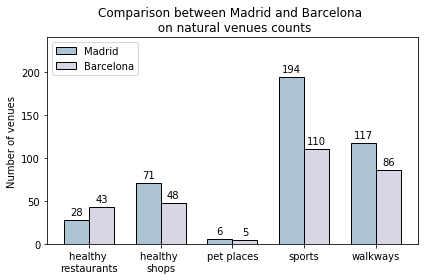

In [27]:
# define labels and datasets
labels = ['healthy \nrestaurants', 'healthy \nshops', 'pet places', 'sports', 'walkways']
madrid_data = grouped_natural['Madrid']
barcelona_data = grouped_natural['Barcelona']

# the label locations
x = np.arange(len(labels))  

# the width of the bars
width = 0.35  

# define figure and axes
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, madrid_data, width, color = '#abc3d3', edgecolor = 'black', label = 'Madrid')
rects2 = ax.bar(x + width/2, barcelona_data, width, color = '#d8d5e5', edgecolor = 'black', label = 'Barcelona')

# define y-axis max value
ax.set_ylim([0,240])

# add text for labels, title and custom x-axis tick labels
ax.set_ylabel('Number of venues')
ax.set_title('Comparison between Madrid and Barcelona \n on natural venues counts')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc = 'upper left')

# define a function to stick text labels to the plot
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy = (rect.get_x() + rect.get_width() / 2, height),
                    
                    # 3 points vertical offset
                    xytext = (0, 3),  
                    textcoords = "offset points",
                    ha = 'center', va = 'bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Following, let´s plot a `box plot` to compare the dispersion in the amount of natural venues per district by city:

[Text(0, 0, 'healthy\n restaurants'),
 Text(0, 0, 'healthy\n shops'),
 Text(0, 0, 'pet places'),
 Text(0, 0, 'sports'),
 Text(0, 0, 'walkways')]

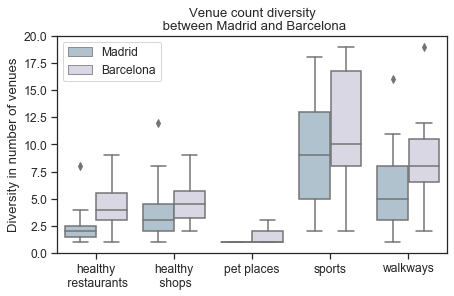

In [28]:
# define some styling to the seaborne plot
sns.set(font_scale = 1.1)
sns.set_style('ticks')

# define custom category labels
label_text = ['healthy\n restaurants', 'healthy\n shops', 'pet places', 'sports', 'walkways']

# define figure size
plt.figure(figsize = (7,4))
plt.ylim(0, 20)

# plot dataset as boxplot
ax = sns.boxplot(x = natural['Natural Category'], y = natural['Venue Count'], hue = natural['City'], data = natural, palette=['#abc3d3', '#d8d5e5'])

# format the plot display
legend = ax.legend()
ax.set(xlabel = None)
ax.set_title('Venue count diversity\n between Madrid and Barcelona')
ax.set_ylabel('Diversity in number of venues')
ax.set_xticklabels(label_text)

### Madrid vs Barcelona - a statistical approach to chose the right destination

We need first to redefine the dataframe we are going to work with by consolidating all natural venues by district and getting a simpler dataset:

In [29]:
# redefine the dataframe to group by district, regardless of category type
natural_ttest = natural.groupby(['City', 'District']).sum().reset_index()

Let´s now define a set for each city which we may need to compare later on:

In [30]:
# extract list from Madrid data
natural_tt_mad = natural_ttest[natural_ttest['City'] == 'Madrid']
set1 = natural_tt_mad['Venue Count'].values.tolist()

# extract list from Barcelona data
natural_tt_bcn = natural_ttest[natural_ttest['City'] == 'Barcelona']
set2 = natural_tt_bcn['Venue Count'].values.tolist()

In order to understand which type of t-test we need to use we will run a prior set of descriptive statistics over the two generated datasets:

In [31]:
# import library
import statistics

# get mean and variance of both sets
print('Madrid districts have a mean of ' + str(statistics.mean(set1)) + ' venues and a variance of ' + str(statistics.variance(set1)))
print('Barcelona districts have a mean of ' + str(statistics.mean(set2)) + ' venues and a variance of ' + str(statistics.variance(set2)))

Madrid districts have a mean of 19.80952380952381 venues and a variance of 119.36190476190477
Barcelona districts have a mean of 29.2 venues and a variance of 131.51111111111112


Since both groups have different sample values, different means and different variances, we'd need to run a t-test for unequal groups:

In [32]:
# import scypy library
from scipy import stats

# t-test for uniqual mean, var and n groups
stats.ttest_ind(set1, set2, equal_var = False)

Ttest_indResult(statistic=-2.163738002875141, pvalue=0.044989635653748576)

### Madrid neighborhoods clustering based on their natural venues profile

#### Generate one-hot encoding dataframe for cluster analysis 

In order to be able to cluster neighborhoods based on their venues' structure (here we are including all venues, not only the 'natural' ones), we need to re-structure our dataframe and generate a one-hot encoding process to distribute in different columns each venue category.

In our case we will also use additional weighting based on the categories occurrence instead of the traditional 1/0 values approach of regular one-hot encoding processes. 

In [33]:
# map rendering library
import folium 

# library to handle JSON files
import json
from pandas import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported')

Libraries imported


In [34]:
# consolidate the dataframe per district and neighborhood
mad_venues = mad_venues.groupby(['District', 'Neighborhood', 'Neighborhood Lat', 'Neighborhood Lon', 'Venue Category']).count().reset_index()
mad_venues = mad_venues[['District', 'Neighborhood', 'Neighborhood Lat', 'Neighborhood Lon', 'Venue Category', 'Venue']]
mad_venues = mad_venues.rename(columns = {"Venue": "Venue Count"})
mad_venues['Neighborhood'] = mad_venues['Neighborhood'].replace(['El Cañaveral', 'Niño Jesus', 'Nueva España', 'Opañel', 'Peñagrande'], ['El Canaveral', 'Nino Jesus', 'Nueva Espana', 'Opanel', 'Penagrande'])

# display dataframes
print('There are ' + str(mad_venues['Venue Category'].nunique()) + ' categories in the dataset')
print(mad_venues.shape)
mad_venues.head()

There are 290 categories in the dataset
(2231, 6)


,District,Neighborhood,Neighborhood Lat,Neighborhood Lon,Venue Category,Venue Count
0,Arganzuela,Acacias,40.401422,-3.704936,Art Gallery,1
1,Arganzuela,Acacias,40.401422,-3.704936,Bakery,1
2,Arganzuela,Acacias,40.401422,-3.704936,Bar,3
3,Arganzuela,Acacias,40.401422,-3.704936,Beach,1
4,Arganzuela,Acacias,40.401422,-3.704936,Beer Bar,2


In [35]:
# one hot encoding
mad_onehot = pd.get_dummies(mad_venues[['Venue Category']], prefix="", prefix_sep="")

# multiply dataframe by values
mad_onehot = mad_onehot * mad_venues[['Venue Count']].values

# changng one venue category name to avoid later conflict on grouping with Neighborhood main variable
mad_onehot = mad_onehot.rename(columns = {"Neighborhood": "Residential"})
print('One-hot encoding dataframe size is: ' + str(mad_onehot.shape))

# create a joined dataframe
mad_temp = pd.concat([mad_venues, mad_onehot], axis = 1)

# drop columns Venue Category and Venue Count
mad_temp = mad_temp.drop(['Venue Category', 'Venue Count'], axis = 1)
print('Temporal dataframe size is: ' + str(mad_temp.shape))

# identify the columns we want to aggregate
group_cols = mad_temp.columns[:4].tolist()

# identify the columns which we want to average
metric_cols = mad_temp.columns[4:].tolist()

# consolidate the dataframe per district and neighborhood
mad_neigh_venues = mad_temp.groupby(group_cols)[metric_cols].sum().reset_index()

# display dataframes
print('Grouped dataframe size is: ' + str(mad_neigh_venues.shape))

One-hot encoding dataframe size is: (2231, 290)
Temporal dataframe size is: (2231, 294)
Grouped dataframe size is: (127, 294)


Since after generating the dataframe we see 4 neighborhoods are missing, likely due to lack of venues represented, we needed to generate an additonal 'fake' dataframe for these ones and merge it with the upper dataframe:

In [36]:
# generate data for the 4 missing neighborhoods
cols = mad_neigh_venues.columns
missing = pd.DataFrame(np.zeros([4, 294]), columns = cols)

# replace first 4 columns by known data
missing['District'] = ['Barajas', 'Moncloa-Aravaca', 'Moratalaz', 'Puente de Vallecas']
missing['Neighborhood'] = ['Alameda de Osuna', 'Casa de Campo', 'Vinateros', 'Entrevias']
missing['Neighborhood Lat'] = [40.428056, 40.481944, 40.403056, 40.400000]
missing['Neighborhood Lon'] = [-3.625278, -3.742500, -3.640278, -3.683333]

# display shape and dataframe
print(missing.shape)

(4, 294)


In [37]:
# create a joined dataframe
mad_neigh_venues = pd.concat([mad_neigh_venues, missing], axis = 0).reset_index()
mad_neigh_venues = mad_neigh_venues.drop(['index'], axis = 1)

# display shape and dataframe
print(mad_neigh_venues.shape)

(131, 294)


#### Generate top 10 venues per neighborhood dataframe

The next step is to focus on the top 10 venues per neighborhood in all the dataset, based on their frequency of appearance over the total amount of venues of every neighborhood:

In [38]:
# define a function to sort the venues in descending order
def return_top_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [39]:
# dropped columns not required
mad_for_top10 = mad_neigh_venues.drop(['District', 'Neighborhood Lat', 'Neighborhood Lon'], 1)

# define the number of top venues
num_top_venues = 10

# include some position indicators
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighborhood'] = mad_for_top10['Neighborhood']

for ind in np.arange(mad_neigh_venues.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_top_venues(mad_for_top10.iloc[ind, :], num_top_venues)

# display shape and dataframe
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(131, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acacias,Park,Spanish Restaurant,Indie Theater,Tapas Restaurant,Bar,Café,Beer Bar,Gym / Fitness Center,Pool,Burger Joint
1,Atocha,Spanish Restaurant,Museum,Bar,Café,Brewery,Bakery,Diner,Gym,Restaurant,Italian Restaurant
2,Chopera,Spanish Restaurant,Restaurant,Bar,Gym,Coffee Shop,Beer Garden,Burger Joint,Mediterranean Restaurant,Flea Market,Argentinian Restaurant
3,Delicias,Restaurant,Spanish Restaurant,Chinese Restaurant,Breakfast Spot,Italian Restaurant,Plaza,Tapas Restaurant,Beer Garden,Electronics Store,Bar
4,Imperial,Tapas Restaurant,Park,Gym / Fitness Center,Hotel,Theater,Pizza Place,Plaza,Spanish Restaurant,Bar,Spa


#### Define clusters of neighborhoods

A fundamental step in the process is defining the clusters of neighborhoods based on their overall venues profile. As we used a k-means clustering process, the first step required is to define the suitable k value or number of clusters:

In [40]:
# prepare dataframe for clustering with k-means
madrid_clustering = mad_for_top10.drop(['Neighborhood'], 1)

# run k-means clustering
for i in range(1,6):
    kmeans = KMeans(n_clusters = i + 1, random_state = 0).fit(madrid_clustering)
    
    # check cluster labels generated for each row in the dataframe
    labels = kmeans.labels_.tolist()
    df = pd.DataFrame({'cluster': labels})
    df['cluster'] = df.groupby(['cluster'])['cluster'].count().astype(int)
    df = df['cluster'][:i+1]
    print("---- " + str(i + 1) + " cluster ----")
    print(df)
    print()

---- 2 cluster ----
0     28.0
1    103.0
Name: cluster, dtype: float64

---- 3 cluster ----
0    78.0
1     8.0
2    45.0
Name: cluster, dtype: float64

---- 4 cluster ----
0    80.0
1    41.0
2     2.0
3     8.0
Name: cluster, dtype: float64

---- 5 cluster ----
0    78.0
1     4.0
2     5.0
3    37.0
4     7.0
Name: cluster, dtype: float64

---- 6 cluster ----
0    62.0
1     4.0
2     5.0
3    12.0
4     6.0
5    42.0
Name: cluster, dtype: float64



By inspecting the distribution of neighborhoods by cluster and the number of clusters in each iteration, we found the best balanced approach was to use k = 4. Based on that value, we run the full clustering process with k-means:

In [41]:
# set number of clusters with the most spread of neighborhoods by cluster
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(madrid_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_.tolist()
df = pd.DataFrame({'cluster': labels})
df['cluster'] = df.groupby(['cluster'])['cluster'].count().astype(int)
df = df['cluster'][:kclusters]
df

0    80.0
1    41.0
2     2.0
3     8.0
Name: cluster, dtype: float64

In [42]:
# add clustering labels to the dataframe
neighborhoods_venues_sorted.insert(0, 'Cluster Number', kmeans.labels_)

# merge = venues_sorted + neigh_coord
mad_for_cluster = pd.merge(mad_neigh_coord, neighborhoods_venues_sorted, on='Neighborhood')

# print shape and dataframe
print(mad_for_cluster.shape)
mad_for_cluster.head()

(131, 15)


,District,Neighborhood,Latitude,Longitude,Cluster Number,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Centro,Palacio,40.415000,-3.713333,3,Tapas Restaurant,Spanish Restaurant,Plaza,Bar,Hotel,Ice Cream Shop,Restaurant,Italian Restaurant,Bistro,Mexican Restaurant
1,Centro,Embajadores,40.408889,-3.699722,2,Restaurant,Plaza,Tapas Restaurant,Bar,Theater,Coffee Shop,Pizza Place,Hotel,Breakfast Spot,Market
2,Centro,Cortes,40.414167,-3.698056,1,Hotel,Plaza,Spanish Restaurant,Theater,Gift Shop,Tapas Restaurant,Art Museum,Garden,Noodle House,Nightclub
3,Centro,Justicia,40.423889,-3.696389,2,Restaurant,Cocktail Bar,Plaza,Clothing Store,Hotel,Café,Coffee Shop,Bar,Tapas Restaurant,Bookstore
4,Centro,Universidad,40.425278,-3.708333,1,Hotel,Bookstore,Café,Plaza,Cocktail Bar,Art Museum,Bar,Spanish Restaurant,Breakfast Spot,Mediterranean Restaurant


Once we have fully defined to which cluster belongs every neighborhood we can display such grouping in a visual way over a map with `Folium` library:

In [43]:
# define latitude and longitude
latitude = mad_neigh_coord['Latitude'][0]
longitude = mad_neigh_coord['Longitude'][0]

# create map
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mad_for_cluster['Latitude'], mad_for_cluster['Longitude'], mad_for_cluster['Neighborhood'], mad_for_cluster['Cluster Number']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

#### Select the most suitable cluster of neighborhoods

Once we defined the clusters, we chose that one which better met our migrants' need for 'natural' venues within the top 10 by neighborhood in the major part of the cluster:

In [44]:
# cluster 1
cluster_1 = mad_for_cluster.loc[mad_for_cluster['Cluster Number'] == 0]
cluster_1 = cluster_1.drop(['District', 'Cluster Number', 'Latitude', 'Longitude'], axis = 1)

# display shape and cluster
print(cluster_1.shape)
cluster_1.head()

(80, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Sol,Cosmetics Shop,Hostel,Hotel,Electronics Store,Mediterranean Restaurant,Pastry Shop,Bookstore,Restaurant,Farmers Market,Exhibit
11,Palos de Moguer,Bar,Bookstore,Tapas Restaurant,Restaurant,Park,Museum,Italian Restaurant,Chinese Restaurant,Sushi Restaurant,Garden
13,Pacifico,Hotel,Spanish Restaurant,Platform,Garden,Gym,Brewery,Food & Drink Shop,Tapas Restaurant,Soccer Field,Bar
17,Los Jeronimos,Restaurant,Hotel,Park,Art Museum,Art Gallery,Event Space,Gastropub,Tapas Restaurant,Garden,City Hall
18,Nino Jesus,Fountain,Supermarket,Tapas Restaurant,Bar,Plaza,Food Court,Food & Drink Shop,Food Service,Food,Flower Shop


In [45]:
# cluster 2
cluster_2 = mad_for_cluster.loc[mad_for_cluster['Cluster Number'] == 1]
cluster_2 = cluster_2.drop(['District', 'Cluster Number', 'Latitude', 'Longitude'], axis = 1)

# cluster 3
cluster_3 = mad_for_cluster.loc[mad_for_cluster['Cluster Number'] == 2]
cluster_3 = cluster_3.drop(['District', 'Cluster Number', 'Latitude', 'Longitude'], axis = 1)

# cluster 4
cluster_4 = mad_for_cluster.loc[mad_for_cluster['Cluster Number'] == 3]
cluster_4 = cluster_4.drop(['District', 'Cluster Number', 'Latitude', 'Longitude'], axis = 1)

# display shape of the other clusters
print('Cluster 2 shape is: ' + str(cluster_2.shape))
print('Cluster 3 shape is: ' + str(cluster_3.shape))
print('Cluster 4 shape is: ' + str(cluster_4.shape))

Cluster 2 shape is: (41, 11)
Cluster 3 shape is: (2, 11)
Cluster 4 shape is: (8, 11)


After a visual inspection **cluster 1** seemed to be the most suitable one for our purposes.

#### Shortlist the 'most natural' neighborhoods from selected cluster

In any case, **cluster 1** was the biggest one, with 80 neighborhoods still in, so a follow-up process to shortlist those to top 10 neighborhoods with a more 'natural' profile within the cluster was run.

To do so, we substituted with a value of **1** those top 10 venues by neighborhood which met a 'natural' profile and with a value of **0** those which not. That made easier to later generate a cumulative value over which to rank the neighborhoods as more or less 'natural'.

A subset of the top 10 'natural' neighborhoods within the cluster was selected to proceed with final analysis upon them:

In [46]:
# list of natural and sport places
natural = ['Mediterranean Restaurant', 'Falafel Restaurant', 'Vegetarian / Vegan Restaurant', 'Spanish Restaurant', 'Juice Bar', 'Farmers Market', 'Grocery Store', 'Fish Market', 'Market', 'Fruit & Vegetable Store', 'Health Food Store', 'Bakery', 'Park', 'Plaza', 'Garden',
           'Pet Store', 'Sports Club', 'Athletics & Sports', 'Soccer Field', 'Soccer Stadium', 'Golf Course', 'Sporting Goods Shop', 'Gym', 'Pool', 'Stadium', 'Dance Studio', 'Gym / Fitness Center', 'Tennis Stadium', 'Racetrack', 'Skating Rink', 'Gym Pool', 'Skate Park', 'Tennis Court', 'Basketball Court', 'Bowling Alley']

# list of non-natural and sport places
non_natural = ['Accessories Store', 'Airport Lounge', 'Airport Service', 'Airport Terminal', 'American Restaurant', 'Aquarium', 'Arcade', 'Argentinian Restaurant', 'Art Gallery', 'Art Museum', 'Asian Restaurant', 'Auto Workshop', 'Bar', 'BBQ Joint', 'Bed & Breakfast', 'Beer Bar', 'Beer Garden', 'Big Box Store', 'Bistro', 'Boarding House', 'Bookstore', 'Boutique', 'Brazilian Restaurant', 'Breakfast Spot', 'Brewery', 'Bubble Tea Shop', 'Building', 'Burger Joint', 'Bus Station', 'Café', 'Cafeteria', 'Camera Store', 'Campground', 'Candy Store', 'Chinese Restaurant', 'Chocolate Shop', 'Circus', 'City Hall', 'Clothing Store', 'Cocktail Bar', 'Coffee Shop', 'College Cafeteria', 'College Residence Hall', 'Colombian Restaurant', 'Comfort Food Restaurant', 'Concert Hall', 'Construction & Landscaping', 'Convenience Store', 'Cosmetics Shop', 'Cupcake Shop', 'Deli / Bodega', 'Department Store', 'Dessert Shop', 'Diner', 'Duty-free Shop', 'Electronics Store', 'Embassy / Consulate', 'Escape Room', 'Event Space', 'Exhibit', 'Fabric Shop', 'Fast Food Restaurant', 'Fish & Chips Shop', 'Flea Market', 'Flower Shop', 'Food', 'Food & Drink Shop', 'Food Court', 'Food Service', 'Food Truck', 'Fountain', 'Furniture / Home Store', 'Gas Station', 'Gastropub', 'General Entertainment', 'German Restaurant', 'Himalayan Restaurant', 'Hostel', 'Hotel', 'Ice Cream Shop', 'Indian Restaurant', 'Irish Pub', 'IT Services', 'Italian Restaurant', 'Japanese Restaurant', 'Karaoke Bar', 'Kebab Restaurant', 'Latin American Restaurant', 'Light Rail Station', 'Lingerie Store', 'Lottery Retailer', 'Massage Studio', 'Metro Station', 'Mexican Restaurant', 'Miscellaneous Shop', 'Mobile Phone Shop', 'Monument / Landmark', 'Motorcycle Shop', 'Multiplex', 'Museum', 'Music School', 'Music Store', 'Music Venue', 'New American Restaurant', 'Nightclub', 'Office', 'Other Repair Shop', 'Paella Restaurant', 'Paper / Office Supplies Store', 'Peruvian Restaurant', 'Pharmacy', 'Photography Studio', 'Pie Shop', 'Pizza Place', 'Platform', 'Playground', 'Pub', 'Public Art', 'Residential', 'Residential Building (Apartment / Condo)', 'Restaurant', 'Rock Club', 'Salon / Barbershop', 'Sandwich Place', 'Scandinavian Restaurant', 'Scenic Lookout', 'Science Museum', 'Seafood Restaurant', 'Shopping Mall', 'Smoke Shop', 'Snack Place', 'Spa', 'Sports Bar', 'Steakhouse', 'Sushi Restaurant', 'Supermarket', 'Tapas Restaurant', 'Tea Room', 'Theater', 'Theme Park', 'Toy / Game Store', 'Track Stadium', 'Trail', 'Train', 'Train Station', 'Video Game Store', "Women's Store", 'Zoo']

# replace natural venues by value 1 and non-natural venues by value 0
cluster = cluster_1[1:].replace(to_replace = [natural], value = 1)
cluster = cluster[1:].replace(to_replace=[non_natural], value=0).reset_index()

# calculate the total value of the neighborhoods by top 10 venues
cluster['Natural Rank'] = cluster.iloc[:, 1:].sum(axis = 1)

# sort neighborhoods by total natural venues value
cluster = cluster.sort_values(by = ['Natural Rank'], ascending=False).reset_index()

# slice dataframe and generate definitive one
natural_neighborhoods = cluster.iloc[:10, :]
natural_neighborhoods = natural_neighborhoods.loc[:, ['Neighborhood', 'Natural Rank']]

We complemented the 'natural' rank value with other information around the average size, and average renting prices of the accommodation in the diverse neighborhoods of the shortlist:

In [47]:
# merge 1 = natural_neighborhoods + buildings
mad_rental_options = pd.merge(natural_neighborhoods, buildings, on='Neighborhood')

# merge 2 = merged + rental
mad_rental_options = pd.merge(mad_rental_options, rental, on='Neighborhood')

# generate a new column with calculated data
mad_rental_options['Average Rental EUR'] = mad_rental_options['Average Home Size m2'] * mad_rental_options['Rental m2 EUR'] 

# attach coordinates to dataframe
neigh_natural = pd.merge(mad_neigh_coord, mad_rental_options, on='Neighborhood')

# sort neighborhoods by total natural venues value
neigh_natural = neigh_natural.sort_values(by = ['Natural Rank'], ascending=False).reset_index().drop(['index'], axis = 1)

# display dataframe
neigh_natural

,District,Neighborhood,Latitude,Longitude,Natural Rank,Average Home Size m2,Rental m2 EUR,Average Rental EUR
0,Fuencarral-El Pardo,Fuentelarreina,40.481944,-3.742500,7,269,12.30,3308.70
1,Moncloa-Aravaca,Valdezarza,40.465000,-3.718333,6,88,12.30,1082.40
2,Carabanchel,Abrantes,40.380556,-3.723889,6,84,10.40,873.60
3,Moratalaz,Horcajo,40.411389,-3.626944,6,141,9.68,1364.88
4,Villaverde,San Cristobal,40.343333,-3.688611,6,69,10.61,732.09
5,Latina,Puerta del Angel,40.411944,-3.729722,5,83,13.10,1087.30
6,Latina,Las Aguilas,40.377500,-3.764167,5,84,10.00,840.00
7,Usera,Almendrales,40.383611,-3.698889,5,91,11.70,1064.70
8,Moratalaz,Media Legua,40.414167,-3.654722,5,99,11.30,1118.70
9,Hortaleza,Apostol Santiago,40.476389,-3.658056,5,109,10.80,1177.20


We displayed over a map with `Folium` this shortlist of neighborhoods too:

In [48]:
# create map of Madrid city using latitude and longitude values
map_neigh_natural = folium.Map(location = [latitude, longitude], zoom_start = 11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neigh_natural['Latitude'], neigh_natural['Longitude'], neigh_natural['District'], neigh_natural['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = 'green',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_neigh_natural)  
    
map_neigh_natural

### Final 'natural' neighborhoods selection based on migrants' salary level

The last step of our analysis was to provide insights to the diverse profiles of migrants, mostly based on their salary levels, about which options from the final pool of 'natural' neighborhoods might be the best for them to enjoy the kind of life they'd like to whilst not putting in danger their economic viability.

In this case, we considered a migrant should never spend more than 40% of the total gross salary in accommodation costs:

In [49]:
# define salary values as integers for later calculations
salary['Year Salary'] = salary['Year Salary'].astype(int)

# group by salary ranges and generate a montly allowance column for renting limit
salary_range = salary.groupby('Range')[['Year Salary', 'Range']].mean().astype(float).round(2)
salary_range['Monthly Allowance (in EUR)'] = ((salary_range['Year Salary'] / 12) * 0.4).astype(float).round(2)
salary_range

,Year Salary,Monthly Allowance (in EUR)
Range,,
1,27671.67,922.39
2,32237.00,1074.57
3,48129.33,1604.31


Finally, let's define 3 exclusive scenarios on possible target neighborhoods to live in based on the salary range defined for the migrant and the average renting price of the accommodation in such neighborhoods:  

In [50]:
# scenario salary range 1
treshold_1 = salary_range.iloc[0,1].astype(float).round(0)

# select doable options for such salary
mad_natural_1 = neigh_natural[neigh_natural['Average Rental EUR'] < treshold_1]
mad_natural_1 = mad_natural_1[['District', 'Neighborhood', 'Natural Rank', 'Average Home Size m2', 'Average Rental EUR']] 
mad_natural_1

,District,Neighborhood,Natural Rank,Average Home Size m2,Average Rental EUR
2,Carabanchel,Abrantes,6,84,873.60
4,Villaverde,San Cristobal,6,69,732.09
6,Latina,Las Aguilas,5,84,840.00


In [51]:
# scenario salary range 2
treshold_2 = salary_range.iloc[1,1].astype(float).round(0)

# select doable options for such salary
mad_natural_2 = neigh_natural[(neigh_natural['Average Rental EUR'] < treshold_2) & (neigh_natural['Average Rental EUR'] > treshold_1)]
mad_natural_2 = mad_natural_2[['District', 'Neighborhood', 'Natural Rank', 'Average Home Size m2', 'Average Rental EUR']] 
mad_natural_2

,District,Neighborhood,Natural Rank,Average Home Size m2,Average Rental EUR
7,Usera,Almendrales,5,91,1064.7


In [52]:
# scenario salary range 3
treshold_3 = salary_range.iloc[2,1].astype(float).round(0)

# select doable options for such salary
mad_natural_3 = neigh_natural[(neigh_natural['Average Rental EUR'] < treshold_3) & (neigh_natural['Average Rental EUR'] > treshold_2)]
mad_natural_3 = mad_natural_3[['District', 'Neighborhood', 'Natural Rank', 'Average Home Size m2', 'Average Rental EUR']] 
mad_natural_3

,District,Neighborhood,Natural Rank,Average Home Size m2,Average Rental EUR
1,Moncloa-Aravaca,Valdezarza,6,88,1082.40
3,Moratalaz,Horcajo,6,141,1364.88
5,Latina,Puerta del Angel,5,83,1087.30
8,Moratalaz,Media Legua,5,99,1118.70
9,Hortaleza,Apostol Santiago,5,109,1177.20


## Results and Discussion

Our analysis showed that Madrid is a better city of choice in Spain for migrants looking for an environment which is full of venues and places where to live following a more 'natural' way of living, even if doing so in the downtown area.

This was proved statistically, being also noticeable that Madrid has more 'natural' venues under all the expected categories (except restaurants), and also that these 'natural' venues have a more homogeneous distribution across the diverse areas of the city there than in Barcelona.  

But choosing one city or the other was only one of the targets of this analysis. After obtaining Madrid as the suitable candidate city for 'natural' migrants, we followed a funneling process to first determine via a k-means clustering analysis which was the best candidate pool of neighborhoods to migrate to within the city, to later go more granular into where to really land based on the migrants' economic level.

We determined 4 was the best and more balanced number of clusters to define a priori during the process. From those, cluster 1, with a big amount of neighborhoods included (80 out of the total 131 neighborhoods in the city of Madrid), seemed the one with a most homogeneous and natural-driven profile of areas included. 

Anyway, as said, having 80 elements in this group would not help much with doing a suitable options recommendation. For this reason we needed to shortlist those to a more manageable amount of top 10 more 'natural' neighborhoods. Surprisingly, there was no specific geographic concentration of these neighborhoods in any given area of the city, with the best candidates being spread all across Madrid downtown.

From those top 10 candidate neighborhoods we found that one, Fuentelarreina, in the North, with huge average house sizes and renting prices, was completely out of scope of any migrant with annual gross salaries below EUR50k. The other 9 candidate neighborhoods appeared in any of the 3 alternative (and exclusive) proposition groups based on salary ranges.

Of course, being that said, for example, someone in the salary range 3 (between EUR40k and EUR50k yearly), like a Doctor or an Architect, would likely chose as a preference to live in the neighborhood of Horcajo. Must be willing to spend money on accommodation in the upper bound of the range, but would be getting in return the highest possible value of 'natural' likeliness (6) and the average biggest houses (141 m$^{2}$) to live in.

## Conclusion

The purpose of this project was to help possible migrant candidates (under a specific 'natural life' persona group) to Spain to chose the best city for them, whether being Madrid or Barcelona.

Once the best candidate city chosen (herein Madrid), we tried to provide the most accurate recommendations possible to narrow down the destination neighborhoods based on their 'natural life' profile likeliness. We also framed alternative options based on the migrants' economic capacity, so that they could choose to spend a fair amount on accommodation while still having the kind of life they would be looking for.   

Of course, this is just a help for migrants to make a documented choice beyond just using a possible job opportunity to decide where to move to. Many other factors like proximity to job place, access to major roads, levels of noise, contamination levels, etc., would also need to be taken into account, and these may need to be handled by the own migrants when trying to make the final decision. 

## Convert .ipynb file into .html

In [53]:
import os

os.system('jupyter nbconvert --to html IBM_capstone_notebook_Madrid_or_Barcelona.ipynb')

0

2021 Sergio Hidalgo - sergio.hidalgo@thetamize.com